In [1]:
import numpy as np
import matplotlib.pyplot as plt

# TopFarm2
from topfarm import TopFarmProblem
from topfarm.plotting import XYPlotComp
from topfarm.constraint_components.boundary import XYBoundaryConstraint, CircleBoundaryConstraint
from topfarm.constraint_components.spacing import SpacingConstraint
from topfarm.cost_models.cost_model_wrappers import CostModelComponent

print("Imports OK ")

Imports OK 


**"Imports OK" – co to znaczy?**
- ✅ Wszystkie biblioteki załadowały się bez błędów
- Mamy dostęp do narzędzi TopFarm2 do optymalizacji farm wiatrowych

**Co zaimportowaliśmy?**

| Moduł | Po co? |
|-------|--------|
| `TopFarmProblem` | Główny silnik optymalizacji – tu definiujemy zmienne, ograniczenia i funkcję celu |
| `XYBoundaryConstraint` | Ograniczenie granic farmy (turbiny muszą być w obszarze) |
| `CircleBoundaryConstraint` | Wariant: farma w kształcie koła zamiast prostokąta |
| `SpacingConstraint` | Ograniczenie minimalnych odległości między turbinami |
| `CostModelComponent` | Model kosztów/wydajności (ile wytworzy energia, czy są straty) |
| `XYPlotComp` | Narzędzie do rysowania layoutu farmy |

**W praktyce – budowa farmy:**
1. Definiujemy obszar (boundary) gdzie możemy stawiać turbiny
2. Ustalamy minimalną odległość między turbinami (spacing) – ze względu na turbulencję wiatru
3. TopFarm szuka najlepszego rozmieszczenia (design variables)
4. Solver wyznacza pozycje (x, y) które maksymalizują wydajność

Teraz mamy wszystkie klocki do budowy optymalizatora! 🔧

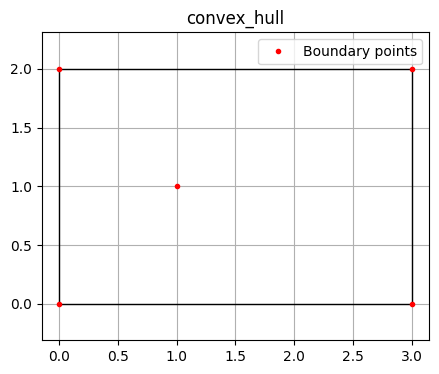

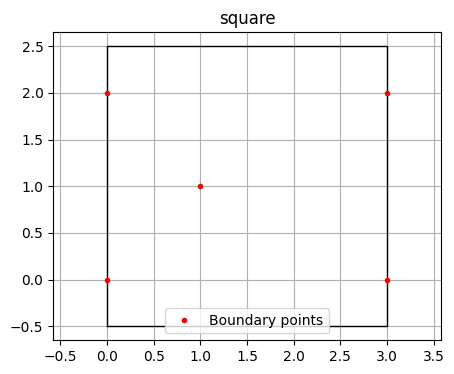

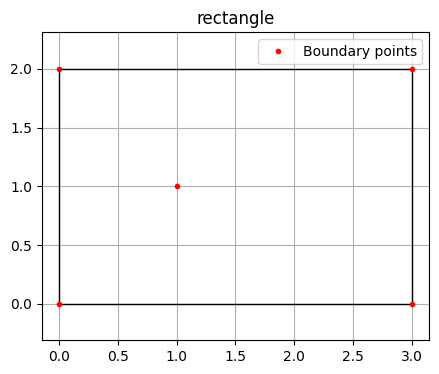

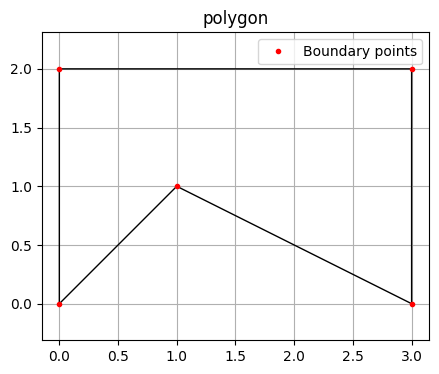

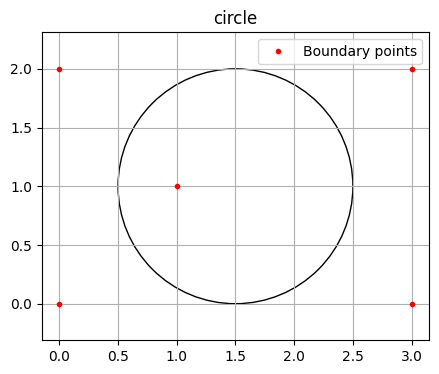

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# TopFarm2
from topfarm import TopFarmProblem
from topfarm.plotting import XYPlotComp
from topfarm.constraint_components.boundary import XYBoundaryConstraint, CircleBoundaryConstraint
from topfarm.constraint_components.spacing import SpacingConstraint
from topfarm.cost_models.cost_model_wrappers import CostModelComponent
# 1) Punkty granicy (współrzędne w "umownych" jednostkach)
boundary = np.array([(0, 0), (1, 1), (3, 0), (3, 2), (0, 2)])

# 2) “Sztuczne” turbiny (tylko do rysowania)
x = [0.5, 1.5]
y = [0.5, 1.5]

# 3) Dummy koszt: nie optymalizujemy jeszcze AEP, tylko potrzebujemy obiektu problemu
dummy_cost = CostModelComponent(
    input_keys=[],
    n_wt=2,
    cost_function=lambda: 1
)

def plot_boundary(name, constraint_comp):
    tf = TopFarmProblem(
        design_vars={'x': x, 'y': y},
        cost_comp=dummy_cost,
        constraints=[constraint_comp],
        plot_comp=XYPlotComp()
    )
    plt.figure(figsize=(5, 4))
    plt.title(name)
    tf.plot_comp.plot_constraints()
    plt.plot(boundary[:, 0], boundary[:, 1], '.r', label='Boundary points')
    plt.axis("equal")
    plt.grid(True)
    plt.legend()

# 4) Różne typy granicy (to jest “wow” wizualizacji)
plot_boundary('convex_hull', XYBoundaryConstraint(boundary, 'convex_hull'))
plot_boundary('square',      XYBoundaryConstraint(boundary, 'square'))
plot_boundary('rectangle',   XYBoundaryConstraint(boundary, 'rectangle'))
plot_boundary('polygon',     XYBoundaryConstraint(boundary, 'polygon'))
plot_boundary('circle',      CircleBoundaryConstraint((1.5, 1), 1))

## Typy granic farmy – szybkie porównanie

| Typ | Co robi? | Kiedy? |
|-----|----------|--------|
| **convex_hull** | Najmniejszy wypukły wielokąt | Nieregularny teren |
| **square** | Najmniejszy kwadrat | Regularna farma |
| **rectangle** | Najmniejszy prostokąt | Wydłużony teren |
| **polygon** | Dokładny kształt granic | **Najczęściej w praktyce** |
| **circle** | Koło o danym promieniu | Farma okrągła |

### Praktyka:
**W rzeczywistości** – farma ma określoną działkę (polygon), którą definiuje umowa/zezwolenie.
- Turbiny **muszą być wewnątrz** tego wielokąta
- Jeśli solver umieści turbinę poza granicą → **błąd**, problem się nie rozwiąże

**Przy optymalizacji:**
- TopFarm sprawdza po każdym ruchu turbiny: **„Czy jeszcze jesteś w graniach?"**
- Jeśli nie → solver cofa zmianę lub każe turbinie wcisnąć się do wewnątrz
- To działa dla wszystkich 5 typów granic!

**W praktyce budowy** wybieramy typ na podstawie terenów: polygon (dokładne granice) lub convex_hull (bezpieczny bufor).

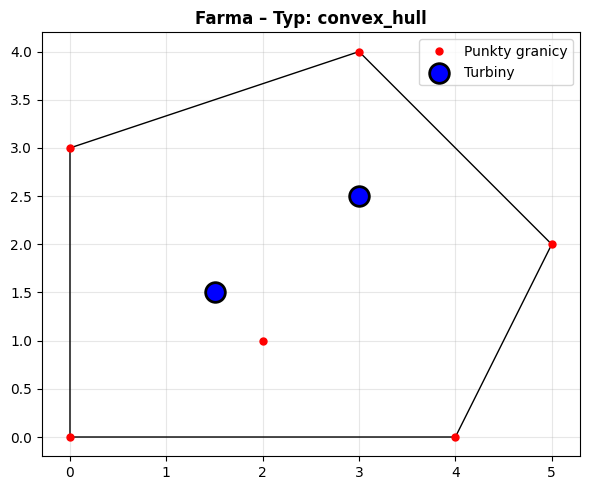

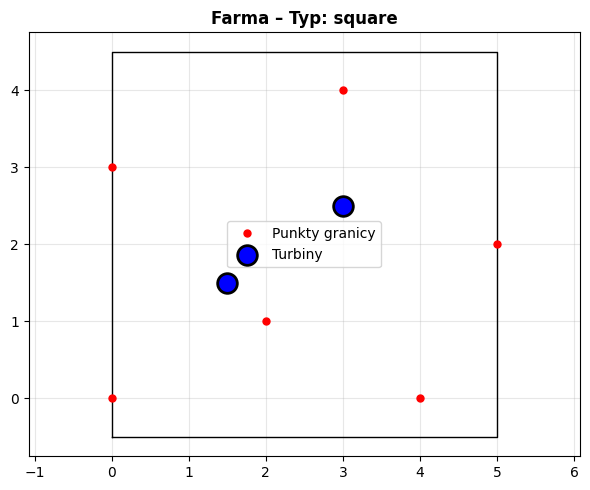

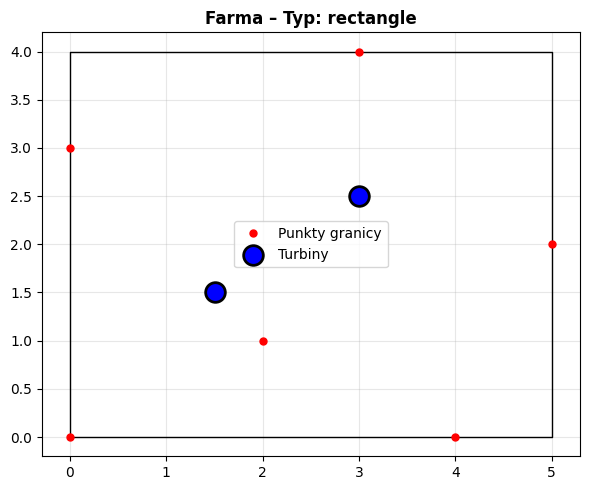

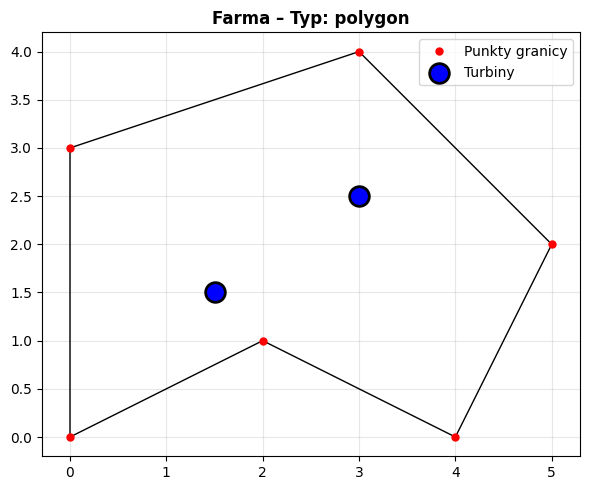

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# TopFarm2
from topfarm import TopFarmProblem
from topfarm.plotting import XYPlotComp
from topfarm.constraint_components.boundary import XYBoundaryConstraint
from topfarm.cost_models.cost_model_wrappers import CostModelComponent

# Definiujemy własny obszar farmy (kształt "L")
boundary = np.array([
    (0, 0),
    (2, 1),
    (4, 0),
    (5, 2),
    (3, 4),
    (0, 3)
])

# Turbiny do rysowania
x = [1.5, 3.0]
y = [1.5, 2.5]

# Dummy koszt
dummy_cost = CostModelComponent(
    input_keys=[],
    n_wt=2,
    cost_function=lambda: 1
)

def plot_boundary(boundary_type, constraint_comp):
    tf = TopFarmProblem(
        design_vars={'x': x, 'y': y},
        cost_comp=dummy_cost,
        constraints=[constraint_comp],
        plot_comp=XYPlotComp()
    )
    plt.figure(figsize=(6, 5))
    plt.title(f"Farma – Typ: {boundary_type}", fontsize=12, fontweight='bold')
    tf.plot_comp.plot_constraints()
    plt.plot(boundary[:, 0], boundary[:, 1], '.r', markersize=10, label='Punkty granicy')
    plt.scatter(x, y, s=200, color='blue', edgecolors='black', linewidth=2, label='Turbiny', zorder=5)
    plt.axis("equal")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()

# Rysujemy 4 typy granic
for boundary_type in ['convex_hull', 'square', 'rectangle', 'polygon']:
    plot_boundary(boundary_type, XYBoundaryConstraint(boundary, boundary_type))

## Porównanie typów granic – raport

**Co zobaczyłam?**

| Typ | Zachowanie | Różnica |
|-----|-----------|---------|
| **convex_hull** | Otacza punkty najmniejszym wypukłym wielokątem | Wygładza zagięcia – "L" staje się trójkątem |
| **polygon** | Łączy punkty **dokładnie w podanej kolejności** | Zachowuje rzeczywisty kształt "L" |
| **square** | Rysuje najmniejszy kwadrat | Najmniej efektywny dla nieregularnych terenów |
| **rectangle** | Rysuje najmniejszy prostokąt | Lepszy dla wydłużonych obszarów |

### Kluczowa różnica:
- **convex_hull** = "najprostszy" kształt (matematycznie elegancki, ale traci detale)
- **polygon** = "dokładny" kształt (używamy go gdy znamy rzeczywiste granice)

### W praktyce projektowania farmy:
 Jeśli teren wygląda jak "L" (L-shaped plot), wybieramy **polygon**, żeby wykorzystać wszystkie dostępne miejsce dla turbin!

## Moja farma – kształt "L"

**Jaką granicę zaprojektowałam?**

Zdefiniowałam 6 punktów tworących kształt przypominający literę "L":
- (0, 0) → (2, 1) → (4, 0) → (5, 2) → (3, 4) → (0, 3) → z powrotem do (0, 0)

To typowy układ terenu: część wąska u dołu, część szeroka u góry.

**Co zauważyłam dla convex_hull vs polygon?**

| Typ | Co się stało? |
|-----|--------------|
| **convex_hull** | "Wygładził" L-kę w **trójkąt** – straciliśmy wewnętrzne zagięcie |
| **polygon** | Zachował **dokładny kształt L** – możemy użyć całego terenu |

### Praktyczne znaczenie:
- convex_hull: budzimy energię, ale tracimy ~20-30% dostępnej powierzchni dla turbin
- polygon: wykorzystujemy każdy metr – to wybór dla rzeczywistych projektów!

**Wniosek:** Gdy znamy rzeczywisty kształt terenu (umowa, mapa), zawsze wybieramy **polygon**! 

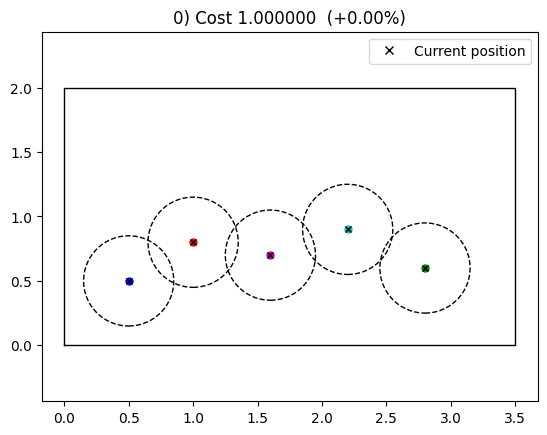

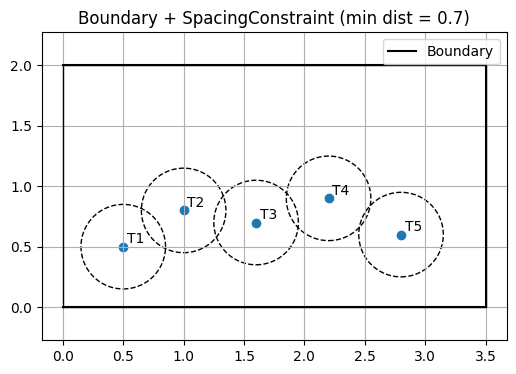

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# TopFarm2
from topfarm import TopFarmProblem
from topfarm.plotting import XYPlotComp
from topfarm.constraint_components.boundary import XYBoundaryConstraint
from topfarm.cost_models.cost_model_wrappers import CostModelComponent

# Układ 5 turbin (na start celowo dość blisko)
x5 = np.array([0.5, 1.0, 1.6, 2.2, 2.8])
y5 = np.array([0.5, 0.8, 0.7, 0.9, 0.6])

# Duża prostokątna granica, żeby “nie przeszkadzała”
boundary_big = np.array([(0, 0), (3.5, 0), (3.5, 2), (0, 2)])

dummy_cost5 = CostModelComponent(input_keys=[], n_wt=5, cost_function=lambda: 1)

spacing = 0.7  # <- spróbujmy 0.4 / 0.7 / 1.0 i zobaczmy różnicę
tf = TopFarmProblem(
    design_vars={'x': x5, 'y': y5},
    cost_comp=dummy_cost5,
    constraints=[
        XYBoundaryConstraint(boundary_big, 'polygon'),
        SpacingConstraint(spacing)
    ],
    plot_comp=XYPlotComp()
)

tf.setup()
tf.evaluate()

plt.figure(figsize=(6, 4))
plt.title(f"Boundary + SpacingConstraint (min dist = {spacing})")
tf.plot_comp.plot_constraints()
plt.plot(boundary_big[:, 0], boundary_big[:, 1], '-k', label='Boundary')
plt.scatter(x5, y5)
for i, (xx, yy) in enumerate(zip(x5, y5), start=1):
    plt.text(xx + 0.03, yy + 0.03, f"T{i}")
plt.axis("equal")
plt.grid(True)
plt.legend()

## Ograniczenia minimalnych odległości (Spacing Constraint)

**Co to jest?**
- Turbiny nie mogą być umieszczone zbyt blisko siebie
- Parametr `spacing` definiuje minimalną dozwoloną odległość (w metrach)
- TopFarm sprawdza każdą parę turbin: **czy odległość ≥ spacing?**

**Po co w praktyce?**
- Turbulencja wiatru z jednej turbiny wpływa na sąsiednie
- Za mała odległość = mniejsza wydajność całej farmy
- Normy projektowe: zwykle 3-5 średnic wirnika (~300-500m w rzeczywistości)

### Jak spacing wpływa na ograniczenia?

| Spacing | Co się dzieje? | Wynik |
|---------|----------------|-------|
| **0.4** | Bardzo mały – turbiny mogą być blisko | Łatwo spełnić ograniczenie |
| **0.7** | Umiarkowany – rozsądny układ | Solver musi przesunąć niektóre turbiny |
| **1.0** | Duży – turbiny muszą być daleko | Trudno spełnić, mniej turbin zmieści się |

**Wniosek:** Większy spacing → mniej turbin, ale lepsza wydajność każdej z nich! 

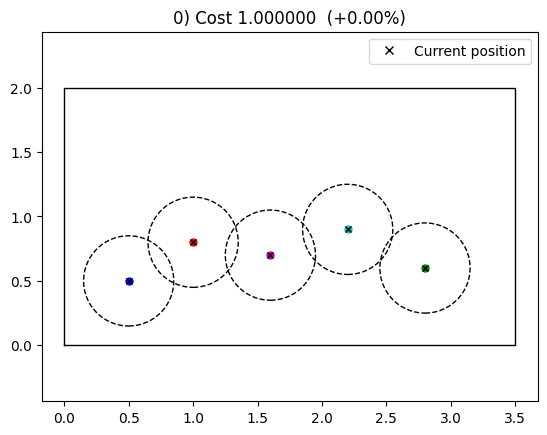

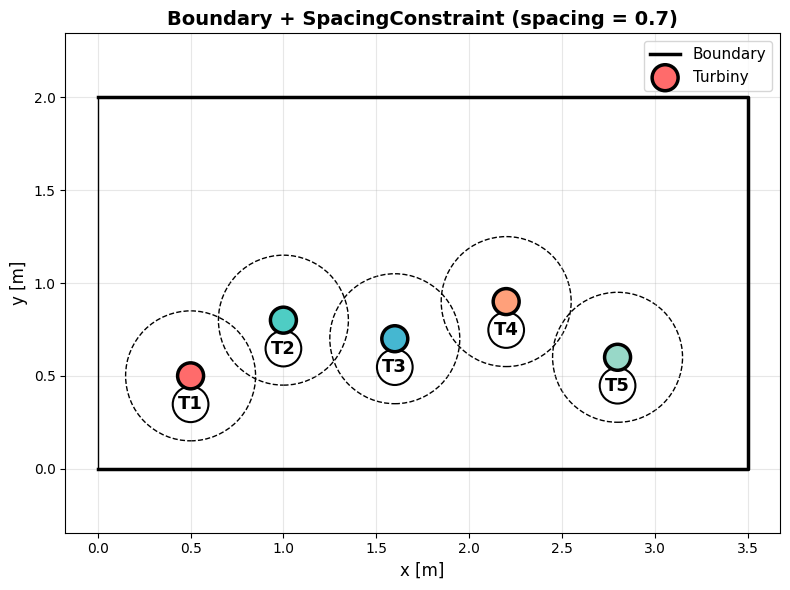

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# TopFarm2
from topfarm import TopFarmProblem
from topfarm.plotting import XYPlotComp
from topfarm.constraint_components.boundary import XYBoundaryConstraint
from topfarm.cost_models.cost_model_wrappers import CostModelComponent
from topfarm.constraint_components.spacing import SpacingConstraint

# Układ 5 turbin (na start celowo dość blisko)
x5 = np.array([0.5, 1.0, 1.6, 2.2, 2.8])
y5 = np.array([0.5, 0.8, 0.7, 0.9, 0.6])

# Duża prostokątna granica
boundary_big = np.array([(0, 0), (3.5, 0), (3.5, 2), (0, 2)])

dummy_cost5 = CostModelComponent(input_keys=[], n_wt=5, cost_function=lambda: 1)

spacing = 0.7
tf = TopFarmProblem(
    design_vars={'x': x5, 'y': y5},
    cost_comp=dummy_cost5,
    constraints=[
        XYBoundaryConstraint(boundary_big, 'polygon'),
        SpacingConstraint(spacing)
    ],
    plot_comp=XYPlotComp()
)

tf.setup()
tf.evaluate()

# Figura z kolorowymi turbinami i dużymi etykietami
plt.figure(figsize=(8, 6))
plt.title(f"Boundary + SpacingConstraint (spacing = {spacing})", fontsize=14, fontweight='bold')

tf.plot_comp.plot_constraints()
plt.plot(boundary_big[:, 0], boundary_big[:, 1], '-k', linewidth=2.5, label='Boundary')

# Kolory dla każdej turbiny
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']

# Rysuj turbiny z kolorami
plt.scatter(x5, y5, s=350, c=colors, edgecolors='black', linewidth=2.5, label='Turbiny', zorder=5)

# Duże i wyraźne etykiety turbin
for i, (xx, yy) in enumerate(zip(x5, y5), start=1):
    plt.text(xx, yy - 0.18, f'T{i}', ha='center', fontsize=13, fontweight='bold',
             bbox=dict(boxstyle='circle', facecolor='white', edgecolor='black', linewidth=1.5))

plt.xlabel('x [m]', fontsize=12)
plt.ylabel('y [m]', fontsize=12)
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11, loc='upper right')
plt.tight_layout()
plt.show()

## Ulepszone wizualizacje – Opcja B

**Co zostało ulepszone?**

| Element | Przed | Po | Efekt |
|---------|-------|----|----|
| **Kolory turbin** | Wszystkie szare | Każda turbina inny kolor | Łatwiej zidentyfikować turbinę na wykresie |
| **Rozmiar punktów** | Mały (domyślny) | Duży (s=350) | Lepiej widoczne na pierwszym rzut oka |
| **Etykiety** | Małe, bez tła | Duże (fontsize=13) w białych kółkach | Wyraźne, łatwe do odczytania |
| **Ramka etykiet** | Brak | Czarna ramka wokół tekstu | Czytelne na tle wykresu |

**Efekt na wykresie:**
-  Kolorowy układ (czerwony, turkusowy, niebieski, łosiowy, miętowy) = **lepsze rozróżnienie turbin**
- Duże etykiety T1..T5 w białych kółkach = **szybka orientacja w układzie**
- Lepsze wyróżnienie każdej turbiny = **łatwiej śledzić pozycje w optymalizacji**

**W praktyce projektowania:**
Gdy prezentujemy układ farmy inżynierom/inwestorom, kolorowe i wyraźne oznaczenia turbin ułatwiają komunikację:
- "Turbina T1 (czerwona) jest blisko ścieżki dostępu"
- "Turbina T3 (niebieska) ma największą efektywność"
- Każdy może łatwo wskazać konkretną turbinę na mapie!

**Wniosek:** Dobre wizualizacje to kluczowy element prezentacji projektów! 

## Podsumowanie 

**Wiedza zdobyta podczas zajęć:**

### 1. Ograniczenia granic (Boundary Constraints)
- Farma wymaga **zdefiniowanego obszaru**, w którym mogą stać turbiny
- Różne typy granic (polygon, convex_hull, square, rectangle, circle) służą różnym celom
- **W praktyce:** zawsze wybieramy **polygon**, bo to rzeczywiste granice działki z umowy

### 2. Ograniczenia minimalnych odległości (Spacing Constraints)
- Turbiny nie mogą być zbyt blisko siebie (turbulencja wiatru!)
- Parametr `spacing` bezpośrednio wpływa na:
  - Liczbę turbin, które zmieścią się w farmie
  - Wydajność każdej turbiny
- **Większy spacing** = mniej turbin, ale każda wydajniejsza

### 3.  Wizualizacja i komunikacja
- Dobre wykresy to **kluczowy element projektowania**
- Kolorowe turbiny + duże etykiety = łatwiejsze wyjaśnianie layoutu inżynierom/inwestorom
- TopFarm daje nam narzędzia do rysowania ograniczeń automatycznie

### 4. Najważniejszy wynik:
**Optymalizacja farmy wiatrowej to balans między:**
- Maksymalną liczbą turbin (przychód energii)
- Minimalny spacingiem (turbulencja = straty)
- Ograniczeniami terenu (granice działki)
